# Laboratorio 2

- **Fecha Inicio**: Miércoles 25 de abril del 2018
- **Fecha Informe**: Domingo 06 de mayo del 2018
- **Integrantes**: Verónica Cestari y Edwin Caminero

## Instalación

Para facilitar el proceso de instalación de esta actividad, trabajaremos con una máquina virtual que tendrá _casi_ todos los programas instalados.

Como motor de máquinas virtuales usaremos [Virtual Box](https://www.virtualbox.org/wiki/Downloads). Desde ese link tendrán que descargar la versión que mejor se ajuste a su sistema operativo. Luego desde los servidores de la universidad deben descargar la [máquina virtual](http://niebla.ing.puc.cl/diplomadobigdata/vbox-pyreclab-lda.ova) ya configurada.

Finalmente debemos importar la máquina descargada dentro de Virtual Box, para ello deben seguir los siguientes pasos: Abrir virtual box > Archivo > Abrir servicio virtualizado, o bien `Crtl+I`.

**Observación:** la contraseña del usuario configurado es _ubuntu_.

Una vez abierto la máquina virtual, abrir la consola o terminal y escribir los siguiente comandos:

```bash
$ sudo apt-get update
$ sudo apt-get install python3-dev
$ sudo apt-get install git
$ sudo pip3 install jupyter
$ sudo pip3 install matplotlib
$ sudo pip3 install pandas
$ sudo pip3 install scipy
$ sudo pip3 install cython
$ sudo pip3 install implicit
$ sudo pip3 install sklearn
```

Descargar este proyecto ya sea con `git` o mediante el botón de descargar y ejecutar `notebook`.

```bash
$ git clone https://github.com/stgolarrain/recsys-labs.git
$ cd recsys-labs/assignment-2
$ jupyter notebook
```

## Instrucciones

En este laboratorio vamos a utilizar la librería [implicit](https://github.com/benfred/implicit), la cual implementa dos modelos de *implicit feedback* con [Bayesian Probabilistic Ranking](https://arxiv.org/pdf/1205.2618.pdf) y [Alternating Least Square (ALS)](https://web.stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf).

Por otro lado, aprenderás a usar la librería [pandas](https://pandas.pydata.org/) para la manipulación de datos a través de *data frames*. En la tercera parte, usaremos la librería [scikit-learn](http://scikit-learn.org/) la cual es considerada un estándar en temas de `machine learning` y modelos predictivos. Recomendamos al alumno revisar la documentación de ambas librerías.
 
También contarán con un pequeño set de datos ubicado en la carpeta `/dataset`, el cual incluye dos archivos: `movies.dat` y `ratings.dat`. Como es de esperarse el archivo `movies.dat` cuenta con metadatos de películas, mientras que `ratings.dat` contiene los *ratings* que diferentes usuarios le asignaron a diferentes películas. El formato de cada archivo es como sigue:

- `movies.dat`: `movie_id; title; genres`
- `ratings.dat`: `user_id; movie_id; rating; timestamp`

Los datos de `genres` corresponden a las categorías de la película separados por el caracter |.

En este laboratorio tendrán que implementar las siguientes tareas:

1. Descripción preliminar del set de datos
2. Entrenar y evaluar cualitativamente los modelos de factorización utilizando ambos métodos
3. Visualizar los vectores latentes mediante la técnica PCA

## 1. Descripción de los Datos

En esta sección utilizaremos la librería [Pandas](https://pandas.pydata.org/) para el manejo de *data frames*.

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [137]:
# Load movies dataset
movies_path = './dataset/movies.dat'
headers = ['movie_id', 'title', 'genres']
movies = pd.read_csv(movies_path,
                     names=headers,
                     delimiter=';')

movies[:5]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [138]:
print('# Movies:', movies['movie_id'].nunique())

# Movies: 3883


**Pregunta** ¿Cuántas películas tiene el set de datos?

**Respuesta**

In [139]:
print('# Cantidad de peliculas:', movies['movie_id'].nunique())

# Cantidad de peliculas: 3883


In [140]:
# Load rating dataset
ratings_path = './dataset/ratings.dat'
headers = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(ratings_path,
                     names=headers,
                     delimiter=';',
                     usecols=['user_id', 'movie_id', 'rating'])

ratings[:5]

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [141]:
# Load rating dataset
ratings_path = './dataset/ratings.dat'
headers = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(ratings_path,
                     names=headers,
                     delimiter=';',
                     usecols=['user_id', 'movie_id', 'rating'])

ratings[:5]

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


**Pregunta** ¿Cuántos usuarios tiene el set de datos?

** Respuesta**

In [142]:
# TODO: Code your answer here
print('# Cantidad de usuarios:', ratings['user_id'].nunique())

# Cantidad de usuarios: 6040


**Pregunta** ¿Cuál es el porcentaje de densidad que tiene la matriz usuario-items

** Respuesta**


In [143]:
cant_users = ratings['user_id'].nunique()
cant_movie = ratings['movie_id'].nunique()
matrix_size = cant_users * cant_movie

density = len(ratings)/matrix_size

print(density*100, '%')

4.468362562231285 %


In [144]:
# Top 5 most popular movies
top_5_count = ratings.groupby(['movie_id'], as_index=False)[['rating']].count().head(5)
top_5_count = top_5_count.merge(movies, on='movie_id', how='inner')
top_5_count

,movie_id,rating,title,genres
0,1,2077,Toy Story (1995),Animation|Children's|Comedy
1,2,701,Jumanji (1995),Adventure|Children's|Fantasy
2,3,478,Grumpier Old Men (1995),Comedy|Romance
3,4,170,Waiting to Exhale (1995),Comedy|Drama
4,5,296,Father of the Bride Part II (1995),Comedy


In [145]:
# Top 5 most like movies (average rating)
top_5_mean_rating = ratings.groupby(['movie_id'], as_index=False)[['rating']].mean().head(5)
top_5_mean_rating = top_5_mean_rating.merge(movies, on='movie_id', how='inner')
top_5_mean_rating

,movie_id,rating,title,genres
0,1,4.146846,Toy Story (1995),Animation|Children's|Comedy
1,2,3.201141,Jumanji (1995),Adventure|Children's|Fantasy
2,3,3.016736,Grumpier Old Men (1995),Comedy|Romance
3,4,2.729412,Waiting to Exhale (1995),Comedy|Drama
4,5,3.006757,Father of the Bride Part II (1995),Comedy


**Pregunta** ¿Cuales son las películas menos populares en términos de cantidad?

*Hint* Te recomendamos utilizar la función [`tail`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.tail.html) de Pandas

**Respuesta**

In [146]:
# TODO: Code your answer here
less_popular = ratings.groupby(['movie_id'], as_index=False)[['rating']].count()
less_popular = less_popular.sort_values(by=['rating'])
less_popular = less_popular.merge(movies, on='movie_id', how='inner')
less_popular.head(5)

,movie_id,rating,title,genres
0,402,1,Open Season (1996),Comedy
1,2214,1,Number Seventeen (1932),Thriller
2,3382,1,Song of Freedom (1936),Drama
3,2217,1,Elstree Calling (1930),Comedy|Musical
4,2218,1,Juno and Paycock (1930),Drama


**Pregunta** ¿Cuales son las películas menos populares en términos de rating promedio?

**Respuesta**

In [147]:
# TODO: Code your answer here
less_mean_ratings = ratings.groupby(['movie_id'], as_index=False)[['rating']].mean()
less_mean_ratings = less_mean_ratings.sort_values(by=['rating'])
less_mean_ratings = less_mean_ratings.merge(movies, on='movie_id', how='inner')
less_mean_ratings.head(5)

,movie_id,rating,title,genres
0,1430,1.0,Underworld (1997),Thriller
1,1165,1.0,"Bloody Child, The (1996)",Drama|Thriller
2,641,1.0,"Little Indian, Big City (Un indien dans la vil...",Comedy
3,3651,1.0,"Blood Spattered Bride, The (La Novia Ensangren...",Horror
4,3228,1.0,Wirey Spindell (1999),Comedy


**Pregunta** Describa las listas de películas menos populares ¿Se parecen las listas de películas menos populares? ¿Por qué?

**Respuesta**

Los valores son distintos, porque la primera lista de peliculas obtiene las menos populares agrupando por id de pelicula que recibieron un rating menor y para la segunda lista se promediaron los ratings para cada pelicula segun los usuarios. 

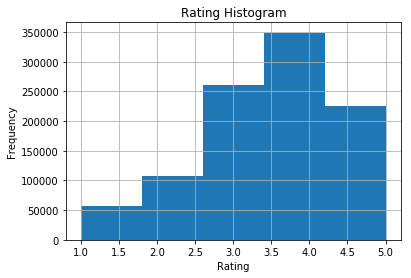

In [148]:
# Rating Histogram
ratings['rating'].hist(bins=5)
plt.title('Rating Histogram')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

**Pregunta**: ¿El set de datos tiene problemas de `cold-start` o ítems con pocos ratings? Justifique generando un histograma con los ratings por usuario y por ítems.

*Hint*: recomendamos utilizar el parámetro bins en el histograma para visualizar la respuesta.

**Respuesta**
Para entender lo solicitado, se armaron varios histogramas dos con los items ordenados de manera ascendente, y dos con los promedios de ratings, en los dos casos se pudo identificar que si existen una cantidad considerable de movies que tienen pocos votos y usuarios que tienen pocos votos, se puede ver mas claro

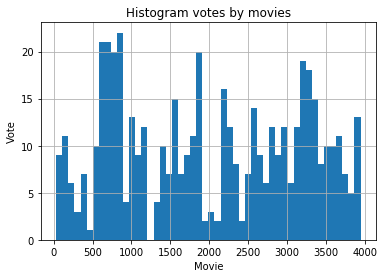

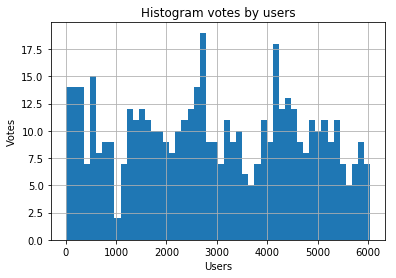

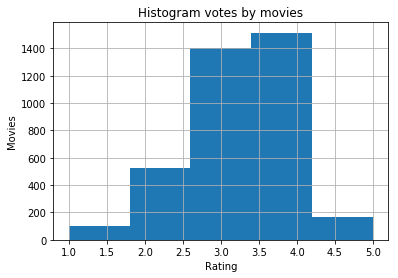

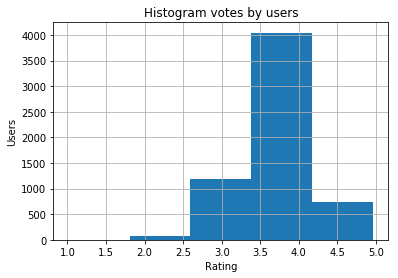

In [149]:
# TODO: Code your answer
items = ratings.groupby(['movie_id'], as_index=False)[['rating']].count()
items = items.sort_values(by=['rating'])
items.head(500)['movie_id'].hist(bins=50) # reducimos el set a 500 para obtener una mejor grafica
#print(items.head(500))
plt.title('Histogram votes by movies')
plt.xlabel('Movie')
plt.ylabel('Vote')
plt.show()

# -----------
users_votes = ratings.groupby(['user_id'], as_index=False)[['rating']].count()
users_votes = users_votes.sort_values(by=['rating'])
users_votes.head(500)['user_id'].hist(bins=50) # reducimos el set a 500 para obtener una mejor grafica
#print(items.head(500))
plt.title('Histogram votes by users')
plt.xlabel('Users')
plt.ylabel('Votes')
plt.show()

# Ratings con promedio

# TODO: Code your answer
items = ratings.groupby(['movie_id'], as_index=False)[['rating']].mean()
items = items.sort_values(by=['rating'])
items['rating'].hist(bins=5)
#print(items.head(500))
plt.title('Histogram votes by movies')
plt.xlabel('Rating')
plt.ylabel('Movies')
plt.show()

# -----------
users_votes = ratings.groupby(['user_id'], as_index=False)[['rating']].mean()
users_votes = users_votes.sort_values(by=['rating'])
users_votes['rating'].hist(bins=5)
# print(users_votes)
plt.title('Histogram votes by users')
plt.xlabel('Rating')
plt.ylabel('Users')
plt.show()





## 2. Factorización Matricial

In [150]:
import implicit
import numpy as np
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking

In [151]:
# Parse data into a sparse matrix
data = ratings

# Generate map for user
unique_users = data['user_id'].unique()
user_to_int = {u: i for i, u in enumerate(unique_users)}
int_to_user = dict(enumerate(unique_users))

# Generate map for movies
unique_movies = data['movie_id'].unique()
movie_to_int = {u: i for i, u in enumerate(unique_movies)}
int_to_movie = dict(enumerate(unique_movies))

# Map user and movies
user_data = data['user_id'].map(lambda u: user_to_int[u]).tolist()
movie_data = data['movie_id'].map(lambda m: movie_to_int[m]).tolist()

data = coo_matrix((data['rating'].astype(np.float32),
                  (movie_data, user_data)))
items = data.T.tocsr()

En la próxima celda generaremos nuestro modelo ALS y lo entrenaremos con los datos de forma implícita.

In [152]:
# Train an ALS model
als_model = AlternatingLeastSquares(factors=50, regularization=0.01, iterations=50)
als_model.fit(data)

En la próxima celda generaremos nuestro modelo BPR y lo entrenaremos con los datos de forma implícita.

In [153]:
# Train a BPR model
bpr_model = BayesianPersonalizedRanking(factors=50, regularization=0.01, iterations=50)
bpr_model.fit(data)

A continuación se implementaron dos funciones que permite generar recomendaciones para un usuario dado un modelo, y otra que permite ver las 10 películas con mejor rating para un usuario. Deberá generar recomendaciones para un usuario utilizando los modelos BPR y ALS; visualizar las películas con mejor rating y responder las siguientes preguntas

In [154]:
# Don't change this cell
def recommend(user_id, model, items, movies, movie_map):
    recommendations = model.recommend(user_id, items)
    df_data = {
        'movie_id': [],
        'scores': []
    }

    for movie_id, score in recommendations:
        df_data['movie_id'].append(movie_map[movie_id])
        df_data['scores'].append(score)
        
    df = pd.DataFrame(data=df_data)
    df = df.merge(movies, on=['movie_id'], how='inner')
        
    return df
    
def show_user(user_id, ratings, movies, movie_map, user_map):
    user_id = user_map[user_id]
    df = ratings[ ratings['user_id'] == user_id].sort_values(['rating'], ascending=False)
    df = df.merge(movies, on=['movie_id'], how='inner')
    return df[:10]

# Usage example
# 
user_id = 0 
recommend(user_id, als_model, items, movies, int_to_movie)
#show_user(user_id, ratings, movies, int_to_movie, int_to_user)

,movie_id,scores,title,genres
0,364,0.960329,"Lion King, The (1994)",Animation|Children's|Musical
1,2858,0.843576,American Beauty (1999),Comedy|Drama
2,318,0.829329,"Shawshank Redemption, The (1994)",Drama
3,1282,0.827195,Fantasia (1940),Animation|Children's|Musical
4,2081,0.808566,"Little Mermaid, The (1989)",Animation|Children's|Comedy|Musical|Romance
5,34,0.782158,Babe (1995),Children's|Comedy|Drama
6,596,0.777271,Pinocchio (1940),Animation|Children's
7,2085,0.777233,101 Dalmatians (1961),Animation|Children's
8,2078,0.768681,"Jungle Book, The (1967)",Animation|Children's|Comedy|Musical
9,2096,0.733169,Sleeping Beauty (1959),Animation|Children's|Musical


In [155]:
# TODO: Code your answer
user_id = 0 
recommend(user_id, bpr_model, items, movies, int_to_movie)

,movie_id,scores,title,genres
0,3460,10.934608,Hillbillys in a Haunted House (1967),Comedy
1,872,10.586279,Aiqing wansui (1994),Drama
2,2592,9.706747,"Joyriders, The (1999)",Drama
3,3323,9.461444,Chain of Fools (2000),Comedy|Crime
4,790,8.982501,An Unforgettable Summer (1994),Drama
5,3065,8.914357,Ten Benny (1997),Drama
6,3321,8.738714,"Waiting Game, The (2000)",Comedy
7,3828,8.713335,Better Living (1998),Comedy
8,3881,8.656315,Bittersweet Motel (2000),Documentary
9,763,8.560565,"Last of the High Kings, The (a.k.a. Summer Fli...",Drama


**Pregunta**: Según tu punto de vista, ¿qué modelo obtuvo la mejor recomendación?

**Respuesta**
Basado en las respuestas obtenidas en los graficos anteriores el modelo `bpr_model`tiene mejor resultado.

**Pregunta**: Según el contenido visto en clases, ¿por qué un modelo genera mejor recomendaciones que otro? Justifique su respuesta.

**Respuesta**:
Basado en lo visto en clases el modelo `Bayesian Probabilistic Ranking` tiene mejor resultado en comparacion del `AlternatingLeastSquares`, esto se debe a unas de las caracteristicas principales de BPR es que busca la similaridad entre los usuarios para asi recomendar o hacer un raking de las peliculas, lo que ofrece un feedback positivo entre usuarios. 

## 3. Visualización de vectores latentes

En esta sección tomaremos los vectores latentes del modelo BPR y aplicaremos una reducción de dimensionalidad a 2D mediante PCA. Luego de ejecutar las próximas celdas, deberá responder las preguntas.

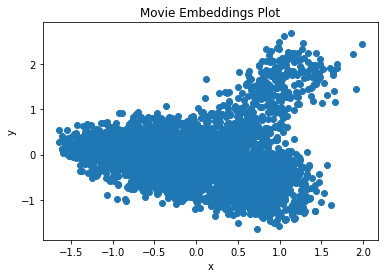

In [156]:
# Don't change this cell
from sklearn.decomposition import PCA

# Train a PCA model
pca = PCA(n_components=2)
data = pca.fit_transform(bpr_model.item_factors)

plt.scatter(data[:, 0], data[:, 1])
plt.title('Movie Embeddings Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

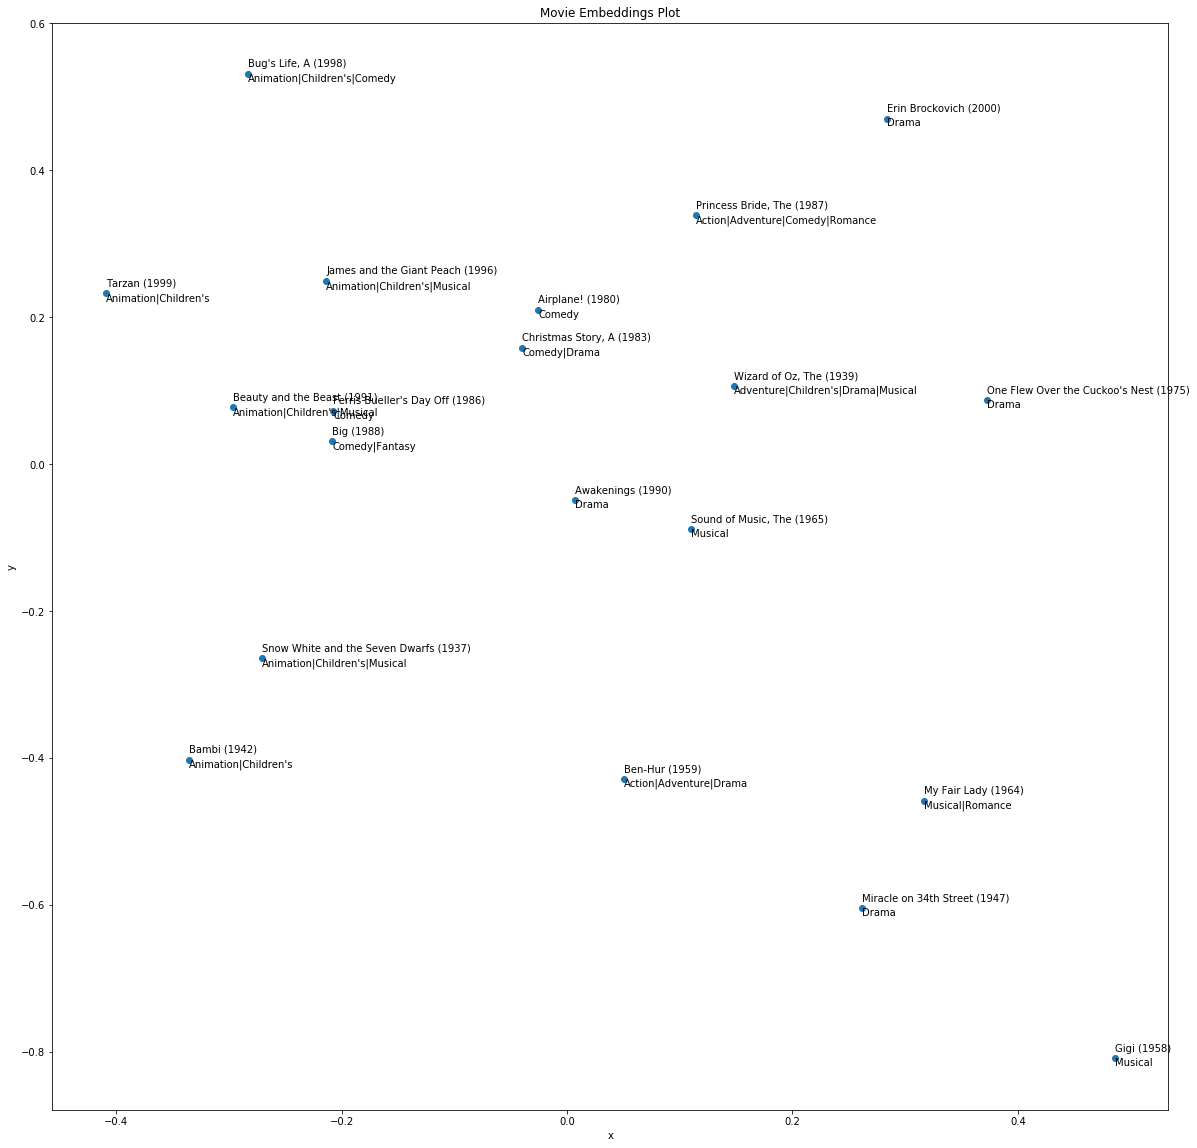

In [157]:
N = 20

# Don't change the under this line
labels = []
categories = []

for i in range(N):
    movie_id = int_to_movie[i]
    movie_name = movies[ movies['movie_id'] == movie_id ]['title'].tolist()[0]
    genres = movies[ movies['movie_id'] == movie_id ]['genres'].tolist()[0]
    
    labels.append(movie_name)
    categories.append(genres)
    

plot_data = data[:N]
plt.figure(figsize=(20,20))
plt.scatter(plot_data[:, 0], plot_data[:, 1])
plt.title('Movie Embeddings Plot')
plt.xlabel('x')
plt.ylabel('y')

# Plot movie names
for i in range(N):
    plt.annotate(labels[i], (plot_data[i, 0], data[i, 1] + .01))
    plt.annotate(categories[i], (plot_data[i, 0], data[i, 1] - .01))

plt.show()

**Pregunta**: Explique en sus palabras qué información capturan los vectores latentes de ítem.

**Respuesta**:
 Los vectores latentes capturan información de los atributos del ítem, además capturan información del gusto de los usuarios sobre estos atributos. Por ejemplo: Se capturaron los géneros de las películas, con su nombre y además cuento le gustaron a los usuarios a través del rating.

**Pregunta**: En base al gráfico anterior, asigne un nombre o explicación a los ejes `x` e `y`.

**Respuesta**:
El enfoque del factor latente, que caracteriza tanto a los usuarios como a la película utilizando dos ejes: Alegría versus Tristezas y Femenino versus masculino.

**Pregunta**: Dado lo aprendido en clases sobre PCA, explique cómo se obtuvieron los ejes `x` e `y`.

**Respuesta**:
Se obtuvieron a través del ítem en el dataset de entrada, donde algunos datos estaban vacios y otros con valor, se aplico una reducción de dimensionalidad y se obtuvieron los valores de dimensiones latentes. La idea del PCA es buscar direcciones donde los datos varían más, esto es una solución basada en SVD.

## Entregable

Una vez completado el laboratorio y respondido las preguntas deberán exportar este archivo en formato `html` y subir a la plataforma _Moodle_.

Para exportar este archivo deben ir a `File > Donwload as > HTML (.html)`

Si tienen algún problema o duda enviar mail a **dparra [at] ing [dot] puc [dot] cl** o **slarrain [at] uc [dot] cl** anteponiendo [Diplomada Bog Data] en el asunto.